### Importing required stuff

In [1]:
import time
import math
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from datetime import timedelta

import scipy.misc
import glob
import sys

%matplotlib inline

### Helper files to load data

In [2]:
# Helper functions, DO NOT modify this

def get_img_array(path):
    """
    Given path of image, returns it's numpy array
    """
    return scipy.misc.imread(path)

def get_files(folder):
    """
    Given path to folder, returns list of files in it
    """
    filenames = [file for file in glob.glob(folder+'*/*')]
    filenames.sort()
    return filenames

def get_label(filepath, label2id):
    """
    Files are assumed to be labeled as: /path/to/file/999_frog.png
    Returns label for a filepath
    """
    tokens = filepath.split('/')
    label = tokens[-1].split('_')[1][:-4]
    if label in label2id:
        return label2id[label]
    else:
        sys.exit("Invalid label: " + label)

In [3]:
# Functions to load data, DO NOT change these

def get_labels(folder, label2id):
    """
    Returns vector of labels extracted from filenames of all files in folder
    :param folder: path to data folder
    :param label2id: mapping of text labels to numeric ids. (Eg: automobile -> 0)
    """
    files = get_files(folder)
    y = []
    for f in files:
        y.append(get_label(f,label2id))
    return np.array(y)

def one_hot(y, num_classes=10):
    """
    Converts each label index in y to vector with one_hot encoding
    """
    y_one_hot = np.zeros((num_classes, y.shape[0]))
    y_one_hot[y, range(y.shape[0])] = 1
    return y_one_hot

def get_label_mapping(label_file):
    """
    Returns mappings of label to index and index to label
    The input file has list of labels, each on a separate line.
    """
    with open(label_file, 'r') as f:
        id2label = f.readlines()
        id2label = [l.strip() for l in id2label]
    label2id = {}
    count = 0
    for label in id2label:
        label2id[label] = count
        count += 1
    return id2label, label2id

def get_images(folder):
    """
    returns numpy array of all samples in folder
    each column is a sample resized to 30x30 and flattened
    """
    files = get_files(folder)
    images = []
    count = 0
    
    for f in files:
        count += 1
        if count % 10000 == 0:
            print("Loaded {}/{}".format(count,len(files)))
        img_arr = get_img_array(f)
        img_arr = img_arr.flatten() / 255.0
        images.append(img_arr)
    X = np.column_stack(images)

    return X

def get_train_data(data_root_path):
    """
    Return X and y
    """
    train_data_path = data_root_path + 'train'
    id2label, label2id = get_label_mapping(data_root_path+'labels.txt')
    print(label2id)
    X = get_images(train_data_path)
    y = get_labels(train_data_path, label2id)
    return X, y

def save_predictions(filename, y):
    """
    Dumps y into .npy file
    """
    np.save(filename, y)

### Load test data from using the helper code from HW1

In [10]:
# Load the data
data_root_path = 'cifar10-hw2/'
X_train, Y_train = get_train_data(data_root_path) # this may take a few minutes
X_test_format = get_images(data_root_path + 'test')
X_test_format = X_test_format.T
#print('Data loading done')

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
Loaded 10000/50000
Loaded 20000/50000
Loaded 30000/50000
Loaded 40000/50000
Loaded 50000/50000
Loaded 10000/10000


In [11]:
X_train = X_train.T
Y_train = Y_train.T

### Load all the data

In [12]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    return data_dict

path = 'cifar-10-batches-py'
file = []
file.append('data_batch_1')
file.append('data_batch_2')
file.append('data_batch_3')
file.append('data_batch_4')
file.append('data_batch_5')
file.append('test_batch')

X_train = None
Y_train = None
X_test = None
Y_test = None

for i in range(6):
    fname = path+'/'+file[i]
    data_dict = unpickle(fname)
    
    _X = np.array(data_dict[b'data'], dtype=float) / 255.0
    _X = _X.reshape([-1, 3, 32, 32])
    _X = _X.transpose([0, 2, 3, 1])
    _X = _X.reshape(-1, 32*32*3)
    _Y = data_dict[b'labels']

    if X_train is None:
        X_train = _X
        Y_train = _Y
    elif i != 5:
        X_train = np.concatenate((X_train, _X), axis=0)
        Y_train = np.concatenate((Y_train, _Y), axis=0)
    else:
        X_test = _X
        Y_test = np.array(_Y)
    print(data_dict[b'batch_label'])

# confirming the output
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
    
    

b'training batch 1 of 5'
b'training batch 2 of 5'
b'training batch 3 of 5'
b'training batch 4 of 5'
b'training batch 5 of 5'
b'testing batch 1 of 1'
(50000, 3072) (50000,) (10000, 3072) (10000,)


### Defining Hyperparameters

In [13]:
# Convolutional Layer 1.
filter_size1 = 3 
num_filters1 = 64

# Convolutional Layer 2.
filter_size2 = 3
num_filters2 = 64

# Fully-connected layer.
fc_1 = 256                 # Number of neurons in fully-connected layer.
fc_2 = 128                 # Number of neurons in fc layer

# Number of color channels for the images: 1 channel for gray-scale.
num_channels = 3

# image dimensions (only squares for now)
img_size = 32

# Size of image when flattened to a single dimension
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# class info
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
num_classes = len(classes)

# batch size
batch_size = 64

# validation split
validation_size = .16

# learning rate 
learning_rate = 0.001

# beta
beta = 0.01

# log directory
import os
log_dir = os.getcwd()

# how long to wait after validation loss stops improving before terminating training
early_stopping = None  # use None if you don't want to implement early stoping

### Helper-function for plotting images
Function used to plot 9 images in a 3x3 grid (or fewer, depending on how many images are passed), and writing the true and predicted classes below each image.

In [14]:
def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
    print(images.shape)   
    images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_size, img_size, num_channels))

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(classes[cls_true[i]])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct

(50000, 3072)


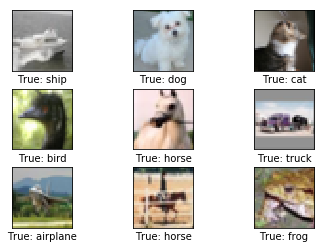

In [15]:
# Plot the images and labels using our helper-function above.
plot_images(X_train, Y_train)

### Normalize

In [12]:
mean = np.mean(X_train, axis = 0)
stdDev = np.std(X_train, axis = 0)

X_train -= mean
X_train /= stdDev

X_test -= mean
X_test /= stdDev

X_test_format -= mean
X_test_format /= stdDev

### Tensorflow graph

### Regularizer

In [16]:
regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

### Weights and Bias

In [17]:
def new_weights(shape):
    return tf.get_variable(name='weights',shape=shape,regularizer=regularizer)

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

### Batch Norm

In [18]:
def batch_norm(x, n_out, phase_train):
    """
    Batch normalization on convolutional maps.
    Ref.: http://stackoverflow.com/questions/33949786/how-could-i-use-batch-normalization-in-tensorflow
    Args:
        x:           Tensor, 4D BHWD input maps
        n_out:       integer, depth of input maps
        phase_train: boolean tf.Varialbe, true indicates training phase
        scope:       string, variable scope
    Return:
        normed:      batch-normalized maps
    """
    with tf.variable_scope('batch_norm'):
        beta = tf.Variable(tf.constant(0.0, shape=[n_out]),
                                     name='beta', trainable=True)
        gamma = tf.Variable(tf.constant(1.0, shape=[n_out]),
                                      name='gamma', trainable=True)
        batch_mean, batch_var = tf.nn.moments(x, [0,1,2], name='moments')
        ema = tf.train.ExponentialMovingAverage(decay=0.5)

        def mean_var_with_update():
            ema_apply_op = ema.apply([batch_mean, batch_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)
            
        mean, var = tf.cond(tf.equal(phase_train,1),
                            mean_var_with_update,
                            lambda: (ema.average(batch_mean), ema.average(batch_var)))
        normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-3)
    return normed

### Helper function for summaries:

In [19]:
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

### Convolutional Layer

In [20]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True, normalize=True, phase=1, batch_normalization =False):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    with tf.variable_scope('weights'):
        weights = new_weights(shape=shape)
        #tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, weights)
        variable_summaries(weights)


    
    # Create new biases, one for each filter.
    with tf.variable_scope('biases'):
        biases = new_biases(length=num_filters)
        variable_summaries(biases)

    
    
    with tf.variable_scope('convolution_layer'):
        layer = tf.nn.conv2d(input=input,
                             filter=weights,
                             strides=[1, 1, 1, 1],
                             padding='SAME')
        # Add the biases to the results of the convolution.
        # A bias-value is added to each filter-channel.
        layer += biases

    #layer = tf.layers.batch_normalization(layer, 
    #                                      center=True, scale=True, 
    #                                      training=phase)
    
    #layer = tf.contrib.layers.batch_norm(layer,is_training=phase)
    # Use pooling to down-sample the image resolution?
    
     # Adding batch_norm
    if batch_normalization == True:
        layer = batch_norm(layer,num_filters, phase)
    
    with tf.variable_scope('Max-Pooling'):
        if use_pooling:
            # This is 2x2 max-pooling, which means that we
            # consider 2x2 windows and select the largest value
            # in each window. Then we move 2 pixels to the next window.
            layer = tf.nn.max_pool(value=layer,
                                   ksize=[1, 2, 2, 1],
                                   strides=[1, 2, 2, 1],
                                   padding='SAME')
    with tf.variable_scope('ReLU'):
        # Rectified Linear Unit (ReLU).
        # It calculates max(x, 0) for each input pixel x.
        # This adds some non-linearity to the formula and allows us
        # to learn more complicated functions.
        layer = tf.nn.relu(layer)

   
    tf.summary.histogram('activations', layer)
    return layer, weights

### Flatten Layer

In [21]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

### FC Layer

In [22]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    with tf.variable_scope('weights'):
        weights = new_weights(shape=[num_inputs, num_outputs])
    
    with tf.variable_scope('biases'):
        biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    with tf.variable_scope('matmul'):
        layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        with tf.variable_scope('relu'):
            layer = tf.nn.relu(layer)

    return layer, weights

### Placeholder variables

In [23]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

y_true_cls = tf.argmax(y_true, axis=1)

phase = tf.placeholder(tf.int32, name='phase')

keep_prob = tf.placeholder(tf.float32, name='keep_prob')

### Convolutional Layers

In [24]:
with tf.variable_scope('Layer-1'):
    layer_conv1, weights_conv1 = \
        new_conv_layer(input=x_image,
                       num_input_channels=num_channels,
                       filter_size=filter_size1,
                       num_filters=num_filters1,
                       use_pooling=True, phase=phase, batch_normalization=True)
        
with tf.variable_scope('Layer-2'):
    layer_conv2, weights_conv2 = \
        new_conv_layer(input=layer_conv1,
                       num_input_channels=num_filters1,
                       filter_size=filter_size2,
                       num_filters=num_filters2,
                       use_pooling=True, phase=phase)
    

### Flatten Layer

In [25]:
with tf.variable_scope('Flatten'):
    layer_flat, num_features = flatten_layer(layer_conv2)

print(layer_flat,num_features)

Tensor("Flatten/Reshape:0", shape=(?, 16384), dtype=float32) 16384


### FC Layers

In [26]:
with tf.variable_scope('Fully-Connected-1'):
    layer_fc1, weights_fc1 = new_fc_layer(input=layer_flat,
                             num_inputs=num_features,
                             num_outputs=fc_1,
                             use_relu=True)
    
with tf.variable_scope('Fully-Connected-2'):
    layer_fc2, weights_fc2 = new_fc_layer(input=layer_fc1,
                             num_inputs=fc_1,
                             num_outputs=fc_2,
                             use_relu=True)
    
with tf.variable_scope('Fully-connected-3'):
    layer_fc3, weights_fc3 = new_fc_layer(input=layer_fc2,
                             num_inputs=fc_2,
                             num_outputs=num_classes,
                             use_relu=False)
    
#with tf.variable_scope('dropout'):
#    layer = tf.nn.dropout(layer_fc2,keep_prob)

### Softmax and argmax functions

In [27]:
with tf.variable_scope('Softmax'):
    y_pred = tf.nn.softmax(layer_fc3)
    y_pred_cls = tf.argmax(y_pred, axis=1)

### Cost-Function:

In [28]:
with tf.variable_scope('cross_entropy_loss'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc3,
                                                        labels=y_true)

    loss = tf.reduce_mean(cross_entropy)
    tf.summary.scalar('cross_entropy', loss)
        
#with tf.variable_scope('Regularization'):
reg_variables = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
reg_term = tf.contrib.layers.apply_regularization(regularizer, reg_variables)
loss += reg_term        
cost = loss
tf.summary.scalar('Total-Loss', cost)

<tf.Tensor 'Total-Loss:0' shape=() dtype=string>

### Using Adam Optimizer

In [29]:
#with tf.variable_scope('Optimize'):
optimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-2).minimize(cost)

### Metrics

In [30]:
with tf.variable_scope('Metrics'):
    correct_prediction = tf.equal(y_pred_cls, y_true_cls)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('accuracy', accuracy)

### Tensorflow Session

In [31]:
session = tf.Session()
session.run(tf.global_variables_initializer())

### Summaries

In [32]:
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(log_dir + '/train', session.graph)
test_writer = tf.summary.FileWriter(log_dir + '/test')

In [33]:
print(X_train.shape)

(50000, 3072)


In [34]:
def one_hot(y, num_classes=10):
    """
    Converts each label index in y to vector with one_hot encoding
    """
    y_one_hot = np.zeros((num_classes, y.shape[0]))
    y_one_hot[y, range(y.shape[0])] = 1
    return y_one_hot

Y_hot = one_hot(Y_train)
Y_hot = Y_hot.T
# split test and train:
x_dev_batch = X_train[0:5000,:]
y_dev_batch = Y_hot[0:5000,:]
X_train = X_train[5000:,:]
Y_hot = Y_hot[5000:,:]

### Training

In [35]:
train_batch_size = batch_size

def print_status(epoch, feed_dict_train, feed_dict_validate, train_loss, val_loss, step):
    # Calculate the accuracy on the training-set.
    summary, acc = session.run([merged,accuracy], feed_dict=feed_dict_train)
    train_writer.add_summary(summary, step)
    summary, val_acc = session.run([merged,accuracy], feed_dict=feed_dict_validate)
    test_writer.add_summary(summary, step)
    msg = "Epoch {0} --- Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%}, Training Loss: {3:.3f}, Validation Loss: {4:.3f}"
    print(msg.format(epoch + 1, acc, val_acc, train_loss, val_loss))
    
# Counter for total number of iterations performed so far.
total_iterations = 0
batch_id = 1

def get_batch(X, Y, batch_size):
    """
    Return minibatch of samples and labels
        
    :param X, y: samples and corresponding labels
    :parma batch_size: minibatch size
    :returns: (tuple) X_batch, y_batch
    """
    global batch_id
    if batch_id*batch_size >= X.shape[0]:
        batch_id = 1
        
    if batch_id == 1:
        permutation = np.random.permutation(X.shape[0])
        X = X[permutation,:]
        Y = Y[permutation,:]
            
    lb = batch_size*(batch_id-1)
    ub = batch_size*(batch_id)

    X = X[lb:ub,:]
    Y = Y[lb:ub,:]
    batch_id += 1
    return X,Y


def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    best_val_loss = float("inf")
    patience = 0

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images
        x_batch, y_true_batch = get_batch(X_train,Y_hot, train_batch_size)
        
        # getting one hot form:
        #y_true_batch = one_hot(y_true_batch)
        #y_dev_batch = one_hot(y_dev_batch)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch, phase: 1, keep_prob:0.5}
        
        feed_dict_validate = {x: x_dev_batch,
                              y_true: y_dev_batch, phase: 0, keep_prob:1.0}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        #print(x_batch.shape,y_true_batch.shape)
        acc = session.run(optimizer, feed_dict=feed_dict_train)
        

        # Print status at end of each epoch (defined as full pass through training dataset).
        if i % int(X_train.shape[0]/batch_size) == 0 == 0: 
            train_loss = session.run(cost, feed_dict=feed_dict_train)
            val_loss = session.run(cost, feed_dict=feed_dict_validate)
            epoch = int(i / int(X_train.shape[0]/batch_size))
            print('Iteration:',i)
            print_status(epoch, feed_dict_train, feed_dict_validate, train_loss, val_loss, i)
            
            if early_stopping:    
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience = 0
                else:
                    patience += 1

                if patience == early_stopping:
                    break

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # close the writers
    train_writer.close()
    test_writer.close()

    # Print the time-usage.
    print("Time elapsed: " + str(timedelta(seconds=int(round(time_dif)))))

In [36]:
# Run the optimizer    
optimize(num_iterations=16873)



Iteration: 0
Epoch 1 --- Training Accuracy:  20.3%, Validation Accuracy:  10.3%, Training Loss: 37.783, Validation Loss: 38.208
Iteration: 703
Epoch 2 --- Training Accuracy:  73.4%, Validation Accuracy:  49.1%, Training Loss: 3.554, Validation Loss: 4.081
Iteration: 1406
Epoch 3 --- Training Accuracy:  64.1%, Validation Accuracy:  59.4%, Training Loss: 1.968, Validation Loss: 2.246
Iteration: 2109
Epoch 4 --- Training Accuracy:  75.0%, Validation Accuracy:  63.1%, Training Loss: 1.387, Validation Loss: 1.665
Iteration: 2812
Epoch 5 --- Training Accuracy:  73.4%, Validation Accuracy:  64.6%, Training Loss: 1.140, Validation Loss: 1.452
Iteration: 3515
Epoch 6 --- Training Accuracy:  76.6%, Validation Accuracy:  66.5%, Training Loss: 1.060, Validation Loss: 1.307
Iteration: 4218
Epoch 7 --- Training Accuracy:  75.0%, Validation Accuracy:  67.1%, Training Loss: 0.947, Validation Loss: 1.183
Iteration: 4921
Epoch 8 --- Training Accuracy:  85.9%, Validation Accuracy:  69.6%, Training Loss: 

In [37]:
Y_test_hot = one_hot(Y_test)
Y_test_hot = Y_test_hot.T
feed_dict_test= {x: X_test,y_true: Y_test_hot, phase: 0, keep_prob:1.0}
summary, acc = session.run([merged,accuracy], feed_dict=feed_dict_test)


In [38]:
print("Accuracy on test set is: %f%%"%(acc*100))

Accuracy on test set is: 71.399993%


### Write out the results

In [39]:
feed_dict_test= {x: X_test_format,y_true: Y_test_hot, phase: 0, keep_prob:1.0}
y_pred = session.run(y_pred, feed_dict=feed_dict_test)
save_predictions('ans1-ck2840.npy', y_pred)

In [40]:
session.close()